# 1. Regression Basics

In [1]:
import os
import pandas as pd

In [2]:
data_folder = '../../../data/examples/module_3'
os.listdir(data_folder)
df = pd.read_csv(f"{data_folder}/democracy_gdp.csv")
df.head(2)

,country,year,v2x_frassoc_thick,NGDPDPC,NGDP_RPCH,v2x_pubcorr,v2xnp_regcorr,v2xel_frefair,v2x_freexp,v2elembcap
0,AFG,1990,0.063,NaN,NaN,0.556,0.538,0.069,0.085,-1.65
1,AFG,1991,0.068,NaN,NaN,0.556,0.538,0.069,0.074,-1.65


## 1.1 Transform data

In [3]:
df_reg = df[['country', 'year','NGDPDPC', 'v2x_freexp']].dropna()
df_reg.head(2)

,country,year,NGDPDPC,v2x_freexp
105,Asia (avg),1990,3749.756571,0.424697
106,Asia (avg),1991,4234.663571,0.444273


In [4]:
import numpy as np
df_reg = df[['country', 'year','NGDPDPC', 'v2x_freexp']].dropna()
df_reg.head(2)
# Log
df_reg['NGDPDPC_log'] = df_reg['NGDPDPC'].apply(np.log)
# pct_change
df_reg['NGDPDPC_chpct1'] = df_reg.groupby('country')['NGDPDPC'].pct_change(1).multiply(100)
# Scale freedom of expresion variable by 100 so it is 0-100 scale
df_reg['v2x_freexp'] = df_reg['v2x_freexp'].multiply(100)
# log
df_reg['v2x_freexp_log'] = df_reg['v2x_freexp'].apply(np.log)
# pct_change
df_reg['v2x_freexp_chpct1'] = df_reg.groupby('country')['v2x_freexp'].pct_change(100)
#
df_reg = df_reg.dropna()
df_reg.head(2)

,country,year,NGDPDPC,v2x_freexp,NGDPDPC_log,NGDPDPC_chpct1,v2x_freexp_log,v2x_freexp_chpct1
625,KOR,1991,7872.91,80.0,8.971183,0.0,4.382027,0.0
626,KOR,1991,7872.91,80.0,8.971183,0.0,4.382027,0.0


In [5]:
df_reg.v2x_freexp.describe()

count    4280.000000
mean       86.970654
std         8.390052
min        58.200000
25%        81.400000
50%        91.500000
75%        93.200000
max        95.600000
Name: v2x_freexp, dtype: float64

## 1.2 Understanding the regression output: A refresher

- r-squared: model fit
- obs: Observations
- const: Constant/ intercept
- coef: coefficient
- P>|t|: pvalue (under .1 statistically significant)

In [6]:
import statsmodels.api as sm
import pandas as pd

def regression_basic(data, y_col, x_col):
    # Prepare data for regression
    y_series, x_series = data[y_col], data[x_col]
    
    # Add constant to the independent variable(s)
    x_with_const = sm.add_constant(x_series, prepend=True)
    
    # Fit the OLS model
    model = sm.OLS(y_series, x_with_const).fit()
    return model.summary()

regression_basic(
    data=df_reg,
    y_col='NGDPDPC_log',
    x_col='v2x_freexp_log',

)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            NGDPDPC_log   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     74.46
Date:                Tue, 27 May 2025   Prob (F-statistic):           8.61e-18
Time:                        15:30:27   Log-Likelihood:                -2345.2
No. Observations:                4280   AIC:                             4694.
Df Residuals:                    4278   BIC:                             4707.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              7.4793      0.276     27.061      0.000       6.937       8.021
v2x_freexp_log     0.5345      0.062      8.629      0.000       0.413       0.656
==============================================================================
Omnibus:                     1657.128   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              214.843
Skew:                          -0.047   Prob(JB):                     2.23e-47
Kurtosis:                       1.906   Cond. No.                         202.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 1.3 Regression: in a simple regression (one x variable) it is a line through a scatter!

In [7]:
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

def regression_and_plot(data, y_col, x_col):
    y_series, x_series = data[y_col], data[x_col]
    x_with_const = sm.add_constant(x_series)
    model = sm.OLS(y_series, x_with_const).fit()

    # Get regression parameters
    intercept, slope = model.params
    rsq = model.rsquared
    p_val = model.pvalues[x_col]  # p-value for the slope

    # Scatter plot
    ax = sns.scatterplot(x=x_col, y=y_col, data=data)
    x_vals = data[x_col]
    y_pred = intercept + slope * x_vals
    ax.plot(x_vals, y_pred, color='red')

    # Annotations
    significance = 'significant' if p_val < 0.05 else 'not significant'
    r_square_interpret = 'model explain variation in GDP' if rsq>.5 else 'Model does not explain much variation in GDP'
    textstr = f'R-square: {rsq:.2f} ({r_square_interpret})\np-value: {p_val:.2f} ({significance})'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.0, -.25, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom', bbox=props)
    plt.title("Explaining GDP (y) with Vdem freedom of expression (x)")

### 1.3.1 Logs

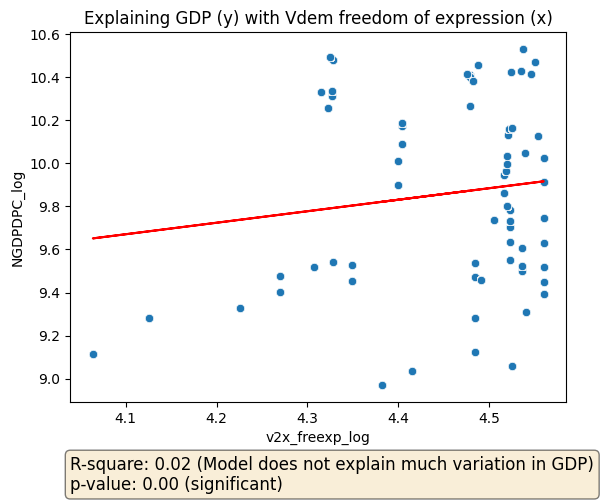

In [8]:
regression_and_plot(
    data=df_reg,
    y_col='NGDPDPC_log',
    x_col='v2x_freexp_log'
)

### 1.3.2 Levels

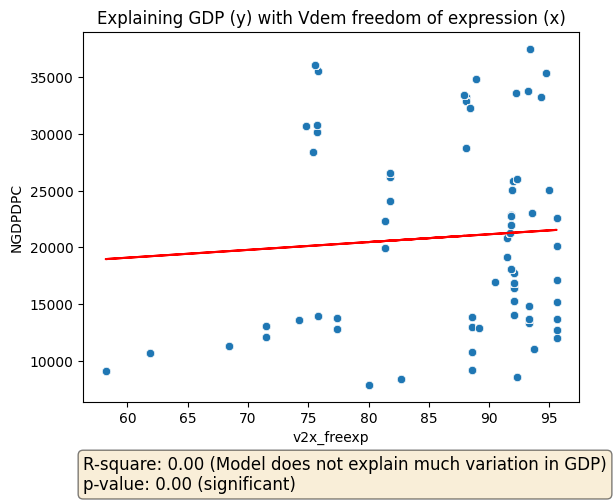

In [9]:
regression_and_plot(
    data=df_reg,
    y_col='NGDPDPC',
    x_col='v2x_freexp'
)

### 1.3.3 Pct Change

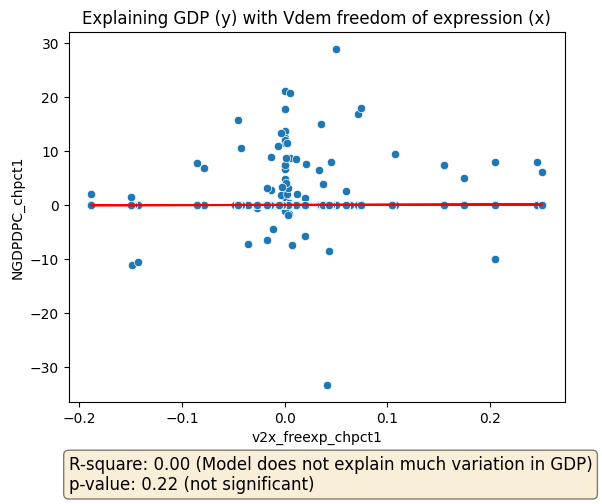

In [10]:
regression_and_plot(
    data=df_reg,
    y_col='NGDPDPC_chpct1',
    x_col='v2x_freexp_chpct1'
)

# 2. Regression with interpretation
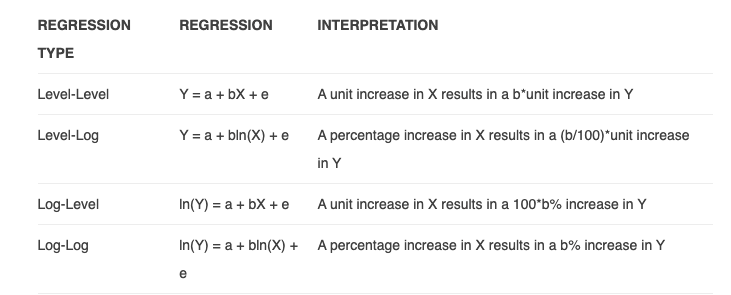


## 2.A Create function

In [11]:
import statsmodels.api as sm
import pandas as pd

def regression_interp(data, y_col, x_col, y_type, x_type, y_name=None, x_name=None, graph=False):
    # Prepare data for regression
    y_series, x_series = data[y_col], data[x_col]
    
    # Add constant to the independent variable(s)
    x_with_const = sm.add_constant(x_series, prepend=True)
    
    # Fit the OLS model
    model = sm.OLS(y_series, x_with_const).fit()
    
    # Get coefficient
    coefficient_scalar = model.params[x_col]
    
    print(f"\n--- Regression Interpretation: {y_name} vs. {x_name} ---")
    print(f"Model: {y_type.capitalize()}-{x_type.capitalize()}")
    print(f"Coefficient: {coefficient_scalar:.3f}")
    
    # Interpretation based on variable types
    if y_type == 'log' and x_type == 'log':  # Log-Log (Elasticity)
        print(f"A 1% increase in {x_name} is associated with a {coefficient_scalar:.3f}% change in {y_name}.")
        
    elif y_type == 'level' and x_type == 'log':  # Level-Log (Semi-elasticity)
        change_in_y_units = coefficient_scalar / 100
        print(f"A 1% increase in {x_name} is associated with a {change_in_y_units:.3f} unit change in {y_name}.")
        
    elif y_type == 'log' and x_type == 'level':  # Log-Level (Semi-elasticity)
        percentage_change_in_y = coefficient_scalar * 100
        print(f"A 1 unit increase in {x_name} is associated with a {percentage_change_in_y:.3f}% change in {y_name}.")
        
    elif y_type == 'level' and x_type == 'level':  # Level-Level (Linear)
        print(f"A 1 unit increase in {x_name} is associated with a {coefficient_scalar:.3f} unit change in {y_name}.")
        
    elif y_type == 'level_pctchange' and x_type == 'level_pctchange':  # Percent change - Percent change
        print(f"A 1 percentage point increase in {x_name} is associated with a {coefficient_scalar:.3f} percentage point change in {y_name}.")
        
    # Handle mixed cases with percent changes
    elif y_type == 'level_pctchange' and x_type == 'level':
        print(f"A 1 unit increase in {x_name} is associated with a {coefficient_scalar:.3f} percentage point change in {y_name}.")
        
    elif y_type == 'level' and x_type == 'level_pctchange':
        print(f"A 1 percentage point increase in {x_name} is associated with a {coefficient_scalar:.3f} unit change in {y_name}.")
        
    elif y_type == 'log' and x_type == 'level_pctchange':
        percentage_change_in_y = coefficient_scalar * 100
        print(f"A 1 percentage point increase in {x_name} is associated with a {percentage_change_in_y:.3f}% change in {y_name}.")
        
    elif y_type == 'level_pctchange' and x_type == 'log':
        change_in_y_pctpts = coefficient_scalar / 100
        print(f"A 1% increase in {x_name} is associated with a {change_in_y_pctpts:.3f} percentage point change in {y_name}.")
        
    
    # Additional model statistics
    print(f"R-squared: {model.rsquared:.2f}" + (f" (Good model fit: Model explains variation in GDP)" if model.rsquared > 0.5 else f" (Bad model fit: Model DOESNT explain variation in GDP)"))
    print(f"P-value: {model.pvalues[x_col]:.3f}" + (f" (Significant)" if model.pvalues[x_col] < 0.05 else f" (Not significant)"))

## 2.1 Comparing different model 

### 2.1.1 Level-Level

In [12]:
regression_interp(data=df_reg,
    y_col='NGDPDPC',
    y_type='level',
    y_name="GDP per capita",
    x_col='v2x_freexp',
    x_type='level',
    x_name="VDEM Freedom of Expression"
)


--- Regression Interpretation: GDP per capita vs. VDEM Freedom of Expression ---
Model: Level-Level
Coefficient: 68.941
A 1 unit increase in VDEM Freedom of Expression is associated with a 68.941 unit change in GDP per capita.
R-squared: 0.00 (Bad model fit: Model DOESNT explain variation in GDP)
P-value: 0.000 (Significant)


### 2.1.2 Log-Level

In [13]:
regression_interp(data=df_reg,
    y_col='NGDPDPC',
    y_type='level',
    y_name="GDP per capita",
    x_col='v2x_freexp_log',
    x_type='log',
    x_name="VDEM Freedom of Expression"
)


--- Regression Interpretation: GDP per capita vs. VDEM Freedom of Expression ---
Model: Level-Log
Coefficient: 6842.942
A 1% increase in VDEM Freedom of Expression is associated with a 68.429 unit change in GDP per capita.
R-squared: 0.01 (Bad model fit: Model DOESNT explain variation in GDP)
P-value: 0.000 (Significant)


### 2.1.3 Level-Log

In [14]:
regression_interp(
    data=df_reg,
    y_col='NGDPDPC',
    y_type='level',
    y_name="GDP per capita",
    x_col='v2x_freexp_log',
    x_type='log',
    x_name="VDEM Freedom of Expression"
)


--- Regression Interpretation: GDP per capita vs. VDEM Freedom of Expression ---
Model: Level-Log
Coefficient: 6842.942
A 1% increase in VDEM Freedom of Expression is associated with a 68.429 unit change in GDP per capita.
R-squared: 0.01 (Bad model fit: Model DOESNT explain variation in GDP)
P-value: 0.000 (Significant)


### 2.1.4 Level pct- Level pct

In [15]:
regression_interp(
    data=df_reg,
    y_col='NGDPDPC_chpct1',
    y_type='level_pctchange',
    y_name="GDP per capita growth rate",
    x_col='v2x_freexp_chpct1',
    x_type='level_pctchange',
    x_name="VDEM Freedom of Expression change"
)



--- Regression Interpretation: GDP per capita growth rate vs. VDEM Freedom of Expression change ---
Model: Level_pctchange-Level_pctchange
Coefficient: 0.352
A 1 percentage point increase in VDEM Freedom of Expression change is associated with a 0.352 percentage point change in GDP per capita growth rate.
R-squared: 0.00 (Bad model fit: Model DOESNT explain variation in GDP)
P-value: 0.224 (Not significant)


### 2.1.5 Log-Log

In [16]:
regression_interp(
    data=df_reg,
    y_col='NGDPDPC_log',
    y_type='log',
    y_name="GDP per capita",
    x_col='v2x_freexp_log',
    x_type='log',
    x_name="VDEM Freedom of Expression"
)


--- Regression Interpretation: GDP per capita vs. VDEM Freedom of Expression ---
Model: Log-Log
Coefficient: 0.535
A 1% increase in VDEM Freedom of Expression is associated with a 0.535% change in GDP per capita.
R-squared: 0.02 (Bad model fit: Model DOESNT explain variation in GDP)
P-value: 0.000 (Significant)


### 2.2 Comparing all previous in one cell

In [17]:
regression_interp(
    data=df_reg,
    y_col='NGDPDPC',
    y_type='level',
    y_name="GDP per capita",
    x_col='v2x_freexp',
    x_type='level',
    x_name="VDEM Freedom of Expression"
)
regression_interp(
    data=df_reg,
    y_col='NGDPDPC',
    y_type='level',
    y_name="GDP per capita",
    x_col='v2x_freexp_log',
    x_type='log',
    x_name="VDEM Freedom of Expression"
)

regression_interp(
    data=df_reg,
    y_col='NGDPDPC_log',
    y_type='log',
    y_name="GDP per capita",
    x_col='v2x_freexp',
    x_type='level',
    x_name="VDEM Freedom of Expression"
)

regression_interp(
    data=df_reg,
    y_col='NGDPDPC_chpct1',
    y_type='level_pctchange',
    y_name="GDP per capita growth rate",
    x_col='v2x_freexp_chpct1',
    x_type='level_pctchange',
    x_name="VDEM Freedom of Expression change"
)

regression_interp(
    data=df_reg,
    y_col='NGDPDPC_log',
    y_type='log',
    y_name="GDP per capita",
    x_col='v2x_freexp_log',
    x_type='log',
    x_name="VDEM Freedom of Expression"
)


--- Regression Interpretation: GDP per capita vs. VDEM Freedom of Expression ---
Model: Level-Level
Coefficient: 68.941
A 1 unit increase in VDEM Freedom of Expression is associated with a 68.941 unit change in GDP per capita.
R-squared: 0.00 (Bad model fit: Model DOESNT explain variation in GDP)
P-value: 0.000 (Significant)

--- Regression Interpretation: GDP per capita vs. VDEM Freedom of Expression ---
Model: Level-Log
Coefficient: 6842.942
A 1% increase in VDEM Freedom of Expression is associated with a 68.429 unit change in GDP per capita.
R-squared: 0.01 (Bad model fit: Model DOESNT explain variation in GDP)
P-value: 0.000 (Significant)

--- Regression Interpretation: GDP per capita vs. VDEM Freedom of Expression ---
Model: Log-Level
Coefficient: 0.006
A 1 unit increase in VDEM Freedom of Expression is associated with a 0.579% change in GDP per capita.
R-squared: 0.01 (Bad model fit: Model DOESNT explain variation in GDP)
P-value: 0.000 (Significant)

--- Regression Interpretati

# 2. Machine learning: Train-Test-Split

## 2.A Import data: Predicting Breast Cancer

In [18]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

# Load the breast cancer dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
X.index.name = 'sample_number'
y = pd.DataFrame(data.target, columns=['target'])
y.index.name = 'sample_number'
X.head(2)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
sample_number,,,,,,,,,,,,,,,,,,,,,
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


In [19]:
y.head(2)

,target
sample_number,
0,0
1,0


## 2.1 Split data for training and test (Random split)

In [20]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head(2)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
sample_number,,,,,,,,,,,,,,,,,,,,,
68,9.029,17.33,58.79,250.5,0.1066,0.1413,0.3130,0.04375,0.2111,0.08046,...,10.31,22.65,65.5,324.7,0.1482,0.4365,1.252,0.1750,0.4228,0.1175
181,21.090,26.57,142.70,1311.0,0.1141,0.2832,0.2487,0.14960,0.2395,0.07398,...,26.68,33.48,176.5,2089.0,0.1491,0.7584,0.678,0.2903,0.4098,0.1284


## 2.2 Random Forest Model (ML)

In [21]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
# Fit model on training data
rf_model.fit(X_train, y_train.values.ravel())

# Make predictions on test data (unseen in training)
y_pred = rf_model.predict(X_test)
y_pred[:2]

array([1, 0])

## 2.3 Show model Results

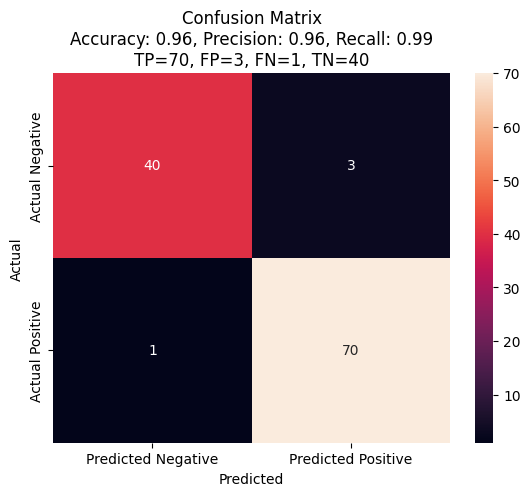

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Get confusion matrix values
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}\nTP={tp}, FP={fp}, FN={fn}, TN={tn}')
plt.show()

# 3. Neural Networks

## 3.A Same data

In [23]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
X.index.name = 'sample_number'
y = pd.DataFrame(data.target, columns=['target'])
y.index.name = 'sample_number'
X.head(2)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
sample_number,,,,,,,,,,,,,,,,,,,,,
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


## 3.1 Train test split

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Assuming X and y are defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

import torch
# Convert to tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train.values.ravel())
y_test = torch.LongTensor(y_test.values.ravel())

## 3.2 Create the neural network

In [26]:
import torch.nn as nn
import torch.optim as optim
# Define Neural Network
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Initialize model, loss function, and optimizer
input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = len(torch.unique(y_train))
model = NeuralNetwork(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 3.3 Train neural network

In [31]:
losses = []

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test).argmax(dim=1)

## 3.4 Show model performance over the course of training

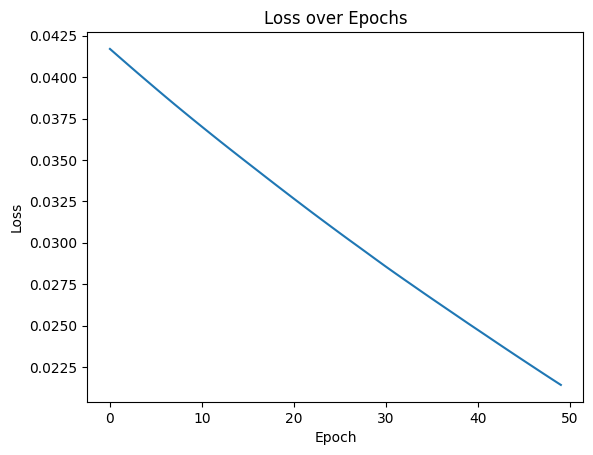

In [32]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

## 3.5 Show final Metrics

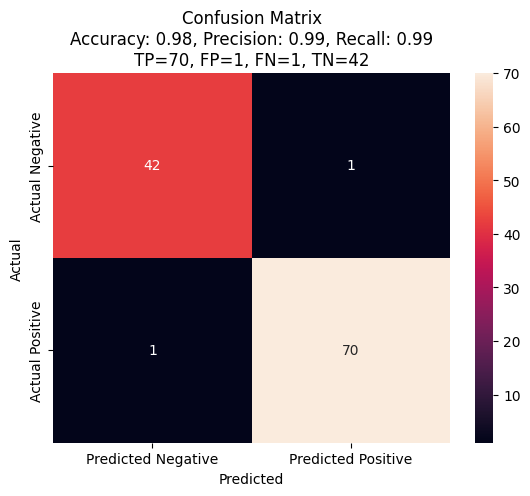

In [55]:
# Get confusion matrix values
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}\nTP={tp}, FP={fp}, FN={fn}, TN={tn}')
plt.show()

## 3.6 Neural Network in a class

Epoch 10/100, Loss: 0.5388
Epoch 20/100, Loss: 0.3455
Epoch 30/100, Loss: 0.1943
Epoch 40/100, Loss: 0.1222
Epoch 50/100, Loss: 0.0880
Epoch 60/100, Loss: 0.0710
Epoch 70/100, Loss: 0.0602
Epoch 80/100, Loss: 0.0522
Epoch 90/100, Loss: 0.0456
Epoch 100/100, Loss: 0.0401

Accuracy: 0.9737
Precision: 0.9740
Recall: 0.9737
Confusion Matrix:
[[42  1]
 [ 2 69]]


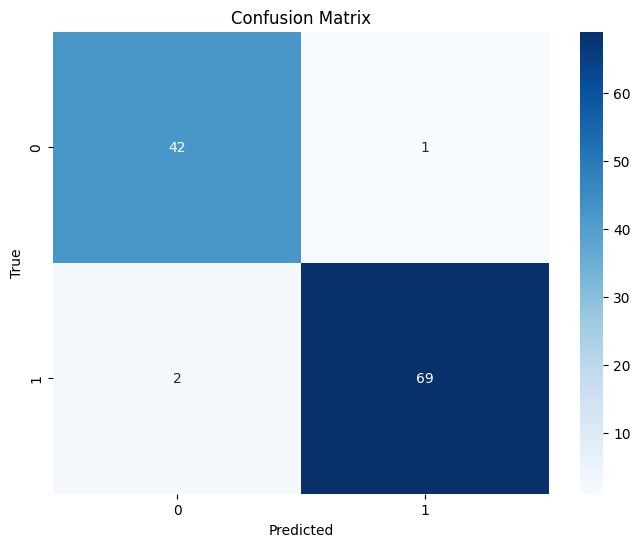

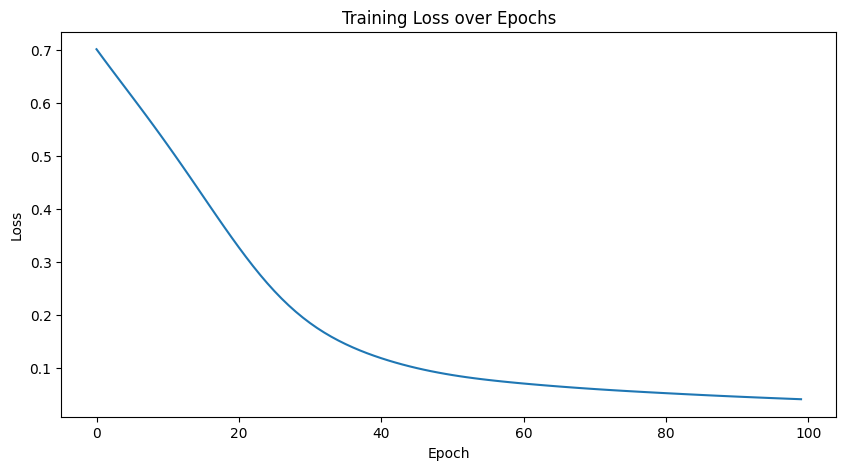

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # Assuming X and y are pandas DataFrames or Series

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

class NeuralNetworkTrainer:
    def __init__(self, X, y, test_size=0.2, random_state=42, hidden_dim=64, learning_rate=0.001, epochs=50):
        self.X = X
        self.y = y
        self.test_size = test_size
        self.random_state = random_state
        self.hidden_dim = hidden_dim
        self.learning_rate = learning_rate
        self.epochs = epochs

        self._prepare_data()
        self._initialize_model()

    def _prepare_data(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=self.test_size, random_state=self.random_state)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        self.X_train = torch.FloatTensor(X_train)
        self.X_test = torch.FloatTensor(X_test)
        self.y_train = torch.LongTensor(y_train.values.ravel())
        self.y_test = torch.LongTensor(y_test.values.ravel())

    def _initialize_model(self):
        input_dim = self.X_train.shape[1]
        output_dim = len(torch.unique(self.y_train))
        self.model = NeuralNetwork(input_dim, self.hidden_dim, output_dim) # Now uses the standalone NeuralNetwork class
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.losses = []

    def train(self):
        for epoch in range(self.epochs):
            self.model.train()
            self.optimizer.zero_grad()
            outputs = self.model(self.X_train)
            loss = self.criterion(outputs, self.y_train)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
            if (epoch + 1) % 10 == 0:
                print(f'Epoch {epoch+1}/{self.epochs}, Loss: {loss.item():.4f}')

    def evaluate(self):
        self.model.eval()
        with torch.no_grad():
            y_pred = self.model(self.X_test).argmax(dim=1)

        y_test_np = self.y_test.cpu().numpy()
        y_pred_np = y_pred.cpu().numpy()

        accuracy = accuracy_score(y_test_np, y_pred_np)
        precision = precision_score(y_test_np, y_pred_np, average='weighted', zero_division=0)
        recall = recall_score(y_test_np, y_pred_np, average='weighted', zero_division=0)
        conf_matrix = confusion_matrix(y_test_np, y_pred_np)

        print(f'\nAccuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'Confusion Matrix:\n{conf_matrix}')

        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(self.losses)
        plt.title('Training Loss over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

        return accuracy, precision, recall, conf_matrix, y_pred



# Initialize and train the model
trainer = NeuralNetworkTrainer(X, y, hidden_dim=64, learning_rate=0.001, epochs=100)

trainer.train()

# Evaluate the model
accuracy, precision, recall, conf_matrix, y_pred_tensor = trainer.evaluate()

# 4. Time series prediction

## 4.A Import data


#### FRED-MD and FRED-QD: Monthly and Quarterly Databases for Macroeconomic Research

- https://www.stlouisfed.org/research/economists/mccracken/fred-databases

In [35]:
import pandas as pd
url = 'https://www.stlouisfed.org/-/media/project/frbstl/stlouisfed/research/fred-md/quarterly/current.csv?sc_lang=en&hash=C6C361D34E485D489591D9E9752CB756'
df = pd.read_csv(url, header = [0], skiprows = [1,2], index_col = [0], parse_dates = True)
df.tail(2)

,GDPC1,PCECC96,PCDGx,PCESVx,PCNDx,GPDIC1,FPIx,Y033RC1Q027SBEAx,PNFIx,PRFIx,...,TNWMVBSNNCBBDIx,TLBSNNBx,TLBSNNBBDIx,TABSNNBx,TNWBSNNBx,TNWBSNNBBDIx,CNCFx,S&P 500,S&P div yield,S&P PE ratio
sasdate,,,,,,,,,,,,,,,,,,,,,
2024-12-01,23542.349,16273.191,2120.961,10736.2567,3452.8476,4315.094,4265.6260,1330.3946,3512.4265,796.6561,...,1013.83,10102033.53,387134.05,22559817.78,12328.82,472.47,2609.4407,5911.05,1.2581,29.9457
2025-03-01,23526.085,16345.560,2102.613,10799.3220,3475.9921,4533.684,4346.5644,1399.5971,3595.4812,799.1808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5900.73,NaN,29.7711


## 4.1 Add features

In [36]:
df['GDP_lead1'] = df['GDPC1'].shift(-1)
#df['GDP_lead1'] = df['GDPC1'].shift(-1)

df = df[['GDP_lead1'] + list(df.columns[:-1])]
df.tail(2)

,GDP_lead1,GDPC1,PCECC96,PCDGx,PCESVx,PCNDx,GPDIC1,FPIx,Y033RC1Q027SBEAx,PNFIx,...,TNWMVBSNNCBBDIx,TLBSNNBx,TLBSNNBBDIx,TABSNNBx,TNWBSNNBx,TNWBSNNBBDIx,CNCFx,S&P 500,S&P div yield,S&P PE ratio
sasdate,,,,,,,,,,,,,,,,,,,,,
2024-12-01,23526.085,23542.349,16273.191,2120.961,10736.2567,3452.8476,4315.094,4265.6260,1330.3946,3512.4265,...,1013.83,10102033.53,387134.05,22559817.78,12328.82,472.47,2609.4407,5911.05,1.2581,29.9457
2025-03-01,NaN,23526.085,16345.560,2102.613,10799.3220,3475.9921,4533.684,4346.5644,1399.5971,3595.4812,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5900.73,NaN,29.7711


## 4.3 Forecast time series 

/var/folders/k9/3kvg9l4d0sz7kr8v4sdn4y_40000gn/T/ipykernel_4734/943222475.py:10: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data = df[[y] + features].pct_change(1).dropna()


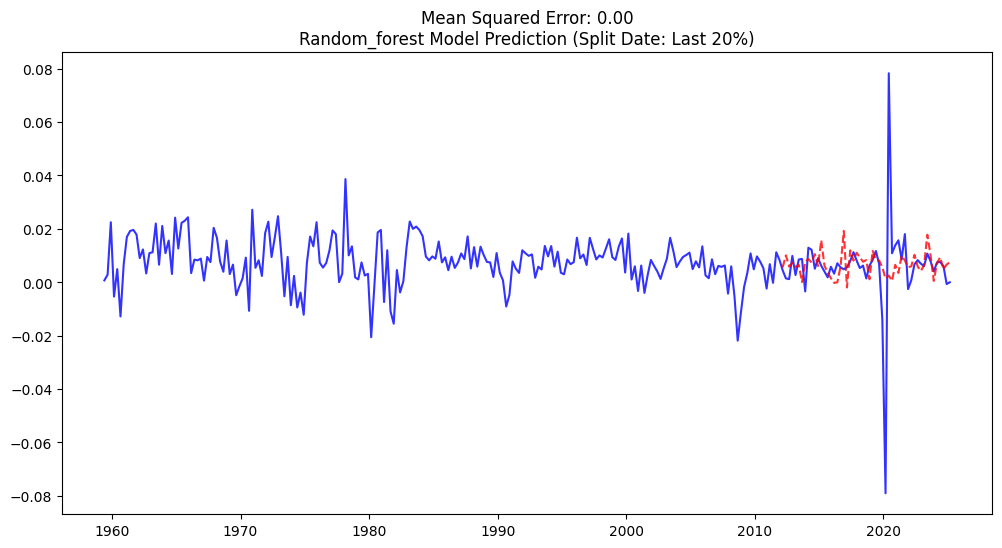

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

def forecast_ml(df, y='GDP_lead1', features=['GPDIC1', 'A823RL1Q225SBEA', 'INDPRO'], standardize=False, model_type='random_forest', split_date=None):

    data = df[[y] + features].pct_change(1).dropna()
    X = data[features]
    y_target = data[y] # Renamed to y_target to avoid conflict with function arg 'y'

    split_index = int(len(data) * 0.8)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y_target.iloc[:split_index], y_target.iloc[split_index:]
    if model_type == 'random_forest':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    elif model_type == 'lasso':
        model = Lasso(alpha=0.1, random_state=42, max_iter=2000) # Added max_iter for convergence
    elif model_type == 'ols':
        model = LinearRegression()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'')

    plt.figure(figsize=(12, 6))
    plt.plot(pd.concat([y_train, y_test], axis=0), label='Actual', alpha=0.8, color='blue')
    plt.plot(pd.Series(y_pred, index=y_test.index), label='Predicted', alpha=0.8, color='red', linestyle='--')
    plt.title(f'Mean Squared Error: {mse:.2f}\n{model_type.capitalize()} Model Prediction (Split Date: {split_datetime.strftime("%Y-%m-%d") if split_date else "Last 20%"})')

forecast_ml(
    df = df,
    y = 'GDP_lead1',
    features = ['GPDIC1', 'INDPRO'],
    
)